# 🌸 Representation Learning on Oxford 102 Flowers Dataset
SimCLR + MAE + ViT | Linear & MLP Probe | t-SNE Visualization

In [2]:
!pip install torchvision timm scikit-learn scipy tqdm

In [3]:

!wget -nc https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget -nc https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar -xvzf 102flowers.tgz


Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [4]:

from scipy.io import loadmat
from pathlib import Path
import shutil
from collections import defaultdict

labels = loadmat("imagelabels.mat")["labels"][0]
image_dir = Path("jpg")
output_dir = Path("flower_split")
train_dir = output_dir / "train"
test_dir = output_dir / "test"

for d in [train_dir, test_dir]:
    for i in range(1, 103):
        (d / f"{i:03d}").mkdir(parents=True, exist_ok=True)

counts = defaultdict(int)
for idx, label in enumerate(labels):
    counts[label] += 1
    src = image_dir / f"image_{idx+1:05d}.jpg"
    dst = train_dir / f"{label:03d}" if counts[label] <= 10 else test_dir / f"{label:03d}"
    shutil.copy(src, dst)


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score



In [6]:

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

classification_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = ImageFolder(str(train_dir), transform=classification_transform)
test_dataset = ImageFolder(str(test_dir), transform=classification_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:

### ✅ SimCLR Implementation (ResNet18 Encoder)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SimCLRModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        base.fc = nn.Identity()
        self.encoder = base
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat((z_i, z_j), dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / self.temperature
        sim_i_j = torch.diag(sim, N)
        sim_j_i = torch.diag(sim, -N)
        positives = torch.cat([sim_i_j, sim_j_i], dim=0).unsqueeze(1)
        mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
        sim = sim.masked_fill(mask, -9e15)
        negatives = sim
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(2 * N, dtype=torch.long).to(z.device)
        return self.criterion(logits, labels)

def train_simclr(model, dataloader, optimizer, loss_fn, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, _ in dataloader:  # ✅ unpack 三個值
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model(x1), model(x2)
            loss = loss_fn(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{epoch+1}] SimCLR Loss: {total_loss / len(dataloader):.4f}")

In [8]:
def plot_tsne(features, labels, title='t-SNE Visualization'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, s=10, palette='tab10', legend=None)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [9]:

### ✅ MAE Implementation
class MAE(nn.Module):
    def __init__(self, input_dim=128*128*3, embed_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image to vector
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon


    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

def train_mae(model, dataloader, optimizer, device, epochs=10):
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            recon = model(x)
            loss = loss_fn(recon, x.view(x.size(0), -1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{epoch+1}] MAE Loss: {total_loss / len(dataloader):.4f}")


In [10]:

### ✅ ViT Baseline (Supervised)
import timm

vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Linear(vit_model.head.in_features, 102)
vit_model = vit_model.to(device)

def train_vit(model, dataloader, optimizer, device, epochs=5):
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{epoch+1}] ViT Loss: {total_loss / len(dataloader):.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)

            # ✅ 支援 SimCLR/ViT: 有 encoder 屬性
            if hasattr(model, "encoder"):
                h = model.encoder(x)

            # ✅ 支援 MAE: 本體即為特徵抽取器
            else:
                if len(x.shape) > 2:
                    x = x.view(x.size(0), -1)  # 展平影像
                h = model(x)

            features.append(h.cpu().numpy())
            labels.append(y.numpy())

    return np.vstack(features), np.concatenate(labels)


## 🧪 SimCLR Pretraining + Evaluation (to be inserted)

In [12]:
# SimCLR 專用增強
contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])

# SimCLR 專用 Dataset 定義（需自訂）
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = self.dataset.loader(path)
        x1 = self.transform(image)
        x2 = self.transform(image)
        return x1, x2, label

# ✅ 修正版本：使用當前資料夾 + 傳入 transform
simclr_dataset = SimCLRDataset("flower_split/train", transform=contrast_transforms)
simclr_loader = DataLoader(simclr_dataset, batch_size=64, shuffle=True)


In [13]:
simclr_model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-4)
loss_fn = NTXentLoss()  # ✅ No batch_size
train_simclr(simclr_model, simclr_loader, optimizer, loss_fn, device, epochs=10)


[1] SimCLR Loss: 4.0211
[2] SimCLR Loss: 3.6619
[3] SimCLR Loss: 3.5799
[4] SimCLR Loss: 3.5241
[5] SimCLR Loss: 3.4907
[6] SimCLR Loss: 3.4533
[7] SimCLR Loss: 3.4159
[8] SimCLR Loss: 3.4018
[9] SimCLR Loss: 3.4035
[10] SimCLR Loss: 3.3989


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def evaluate_probes(train_feats, train_labels, test_feats, test_labels):
    print("✅ Linear Probe")
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_feats, train_labels)
    acc = accuracy_score(test_labels, clf.predict(test_feats))
    print(f"Accuracy: {acc:.4f}")

    print("✅ MLP Classifier")
    mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=300)
    mlp.fit(train_feats, train_labels)
    acc2 = accuracy_score(test_labels, mlp.predict(test_feats))
    print(f"Accuracy: {acc2:.4f}")


🔵 SimCLR Linear & MLP Evaluation
✅ Linear Probe
Accuracy: 0.6530
✅ MLP Classifier
Accuracy: 0.6146


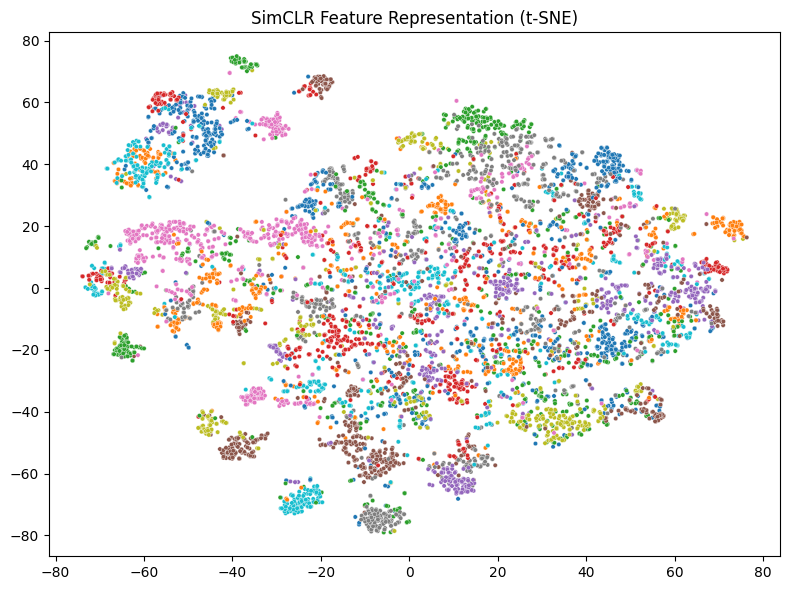

In [15]:
# 🔍 Extract SimCLR Features
simclr_train_feats, simclr_train_labels = extract_features(simclr_model, train_loader, device)
simclr_test_feats, simclr_test_labels = extract_features(simclr_model, test_loader, device)

# 📊 Evaluate Probes on SimCLR
print("🔵 SimCLR Linear & MLP Evaluation")
evaluate_probes(simclr_train_feats, simclr_train_labels, simclr_test_feats, simclr_test_labels)

# 🌈 Visualize SimCLR Representation via t-SNE
simclr_feats, labels = extract_features(simclr_model, test_loader, device)
plot_tsne(simclr_feats, labels, title="SimCLR Feature Representation (t-SNE)")

In [16]:
simclr_model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-4)
loss_fn = NTXentLoss()
train_simclr(simclr_model, simclr_loader, optimizer, loss_fn, device, epochs=20)


[1] SimCLR Loss: 4.0477
[2] SimCLR Loss: 3.6636
[3] SimCLR Loss: 3.5965
[4] SimCLR Loss: 3.5604
[5] SimCLR Loss: 3.4931
[6] SimCLR Loss: 3.4421
[7] SimCLR Loss: 3.4076
[8] SimCLR Loss: 3.4184
[9] SimCLR Loss: 3.4147
[10] SimCLR Loss: 3.3719
[11] SimCLR Loss: 3.3812
[12] SimCLR Loss: 3.3490
[13] SimCLR Loss: 3.3649
[14] SimCLR Loss: 3.3645
[15] SimCLR Loss: 3.3332
[16] SimCLR Loss: 3.3277
[17] SimCLR Loss: 3.3168
[18] SimCLR Loss: 3.3008
[19] SimCLR Loss: 3.3222
[20] SimCLR Loss: 3.3024


✅ Linear Probe
Accuracy: 0.6426
✅ MLP Classifier
Accuracy: 0.6163


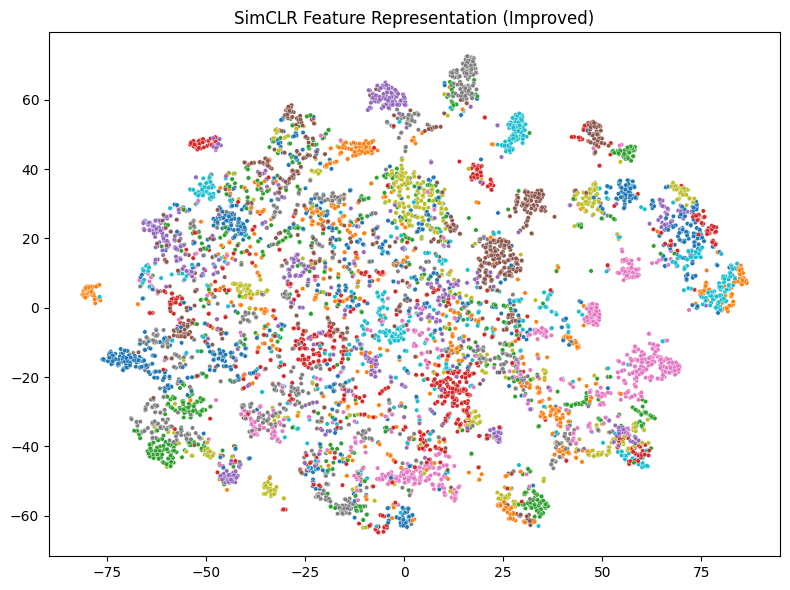

In [17]:
simclr_train_feats, simclr_train_labels = extract_features(simclr_model, train_loader, device)
simclr_test_feats, simclr_test_labels = extract_features(simclr_model, test_loader, device)

evaluate_probes(simclr_train_feats, simclr_train_labels, simclr_test_feats, simclr_test_labels)
plot_tsne(simclr_test_feats, simclr_test_labels, title="SimCLR Feature Representation (Improved)")



## 🧠 MAE Pretraining + Evaluation (to be inserted)

In [18]:
mae_model = MAE().to(device)
optimizer = torch.optim.Adam(mae_model.parameters(), lr=3e-4)
train_mae(mae_model, train_loader, optimizer, device=device, epochs=10)


[1] MAE Loss: 0.0918
[2] MAE Loss: 0.0858
[3] MAE Loss: 0.0657
[4] MAE Loss: 0.0575
[5] MAE Loss: 0.0569
[6] MAE Loss: 0.0563
[7] MAE Loss: 0.0564
[8] MAE Loss: 0.0563
[9] MAE Loss: 0.0559
[10] MAE Loss: 0.0558


In [19]:
mae_train_feats, mae_train_labels = extract_features(mae_model, train_loader, device)
mae_test_feats, mae_test_labels = extract_features(mae_model, test_loader, device)

evaluate_probes(mae_train_feats, mae_train_labels, mae_test_feats, mae_test_labels)


✅ Linear Probe
Accuracy: 0.0261
✅ MLP Classifier
Accuracy: 0.0234


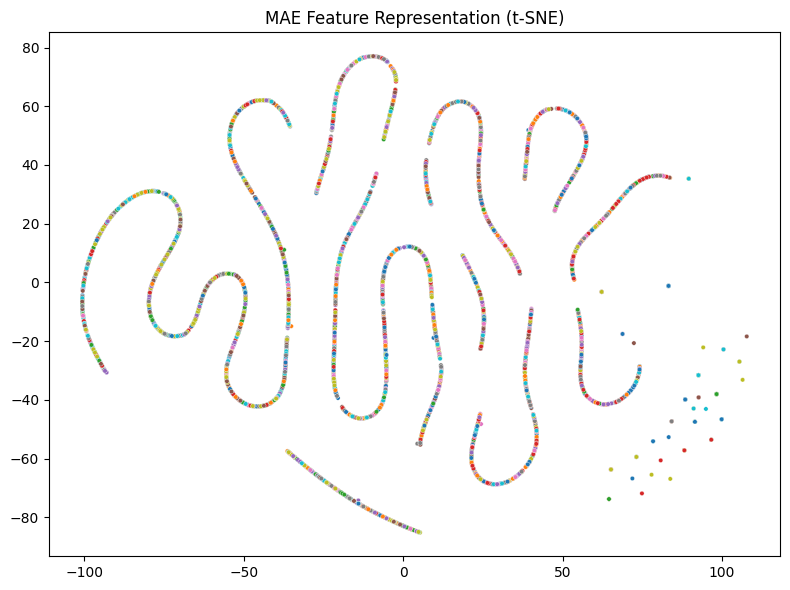

In [20]:
mae_feats, labels = extract_features(mae_model, test_loader, device)
plot_tsne(mae_feats, labels, title="MAE Feature Representation (t-SNE)")


[1] MAE Loss: 0.0990
[2] MAE Loss: 0.0674
[3] MAE Loss: 0.0572
[4] MAE Loss: 0.0553
[5] MAE Loss: 0.0513
[6] MAE Loss: 0.0492
[7] MAE Loss: 0.0481
[8] MAE Loss: 0.0464
[9] MAE Loss: 0.0454
[10] MAE Loss: 0.0444
[11] MAE Loss: 0.0427
[12] MAE Loss: 0.0409
[13] MAE Loss: 0.0400
[14] MAE Loss: 0.0393
[15] MAE Loss: 0.0393
[16] MAE Loss: 0.0390
[17] MAE Loss: 0.0381
[18] MAE Loss: 0.0384
[19] MAE Loss: 0.0375
[20] MAE Loss: 0.0372
✅ Linear Probe


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.1130
✅ MLP Classifier


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.0939


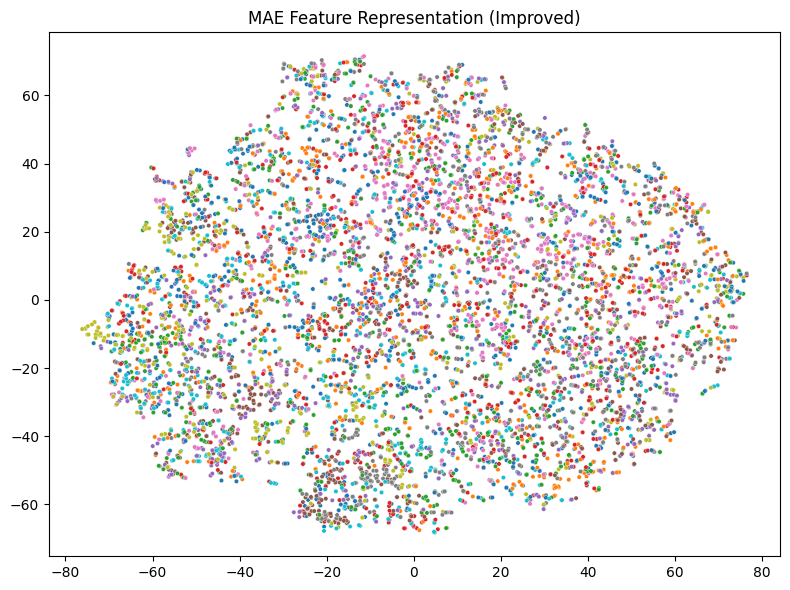

In [21]:
# ✅ 8. 啟動訓練與評估
mae_model = MAE().to(device)
optimizer = torch.optim.Adam(mae_model.parameters(), lr=1e-3, weight_decay=1e-5)
train_mae(mae_model, train_loader, optimizer, device=device, epochs=20)

mae_train_feats, mae_train_labels = extract_features(mae_model, train_loader, device)
mae_test_feats, mae_test_labels = extract_features(mae_model, test_loader, device)

evaluate_probes(mae_train_feats, mae_train_labels, mae_test_feats, mae_test_labels)
plot_tsne(mae_test_feats, mae_test_labels, title="MAE Feature Representation (Improved)")

## 🧾 ViT Baseline Supervised + t-SNE

In [22]:

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_features(model, dataloader, device):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            h = model.encoder(x).cpu().numpy()
            feats.append(h)
            labels.append(y.numpy())
    return np.vstack(feats), np.concatenate(labels)

def evaluate_probes(train_feats, train_labels, test_feats, test_labels):
    print("✅ Linear Probe")
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_feats, train_labels)
    print("Accuracy:", accuracy_score(test_labels, clf.predict(test_feats)))
    print("✅ MLP Classifier")
    mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=300)
    mlp.fit(train_feats, train_labels)
    print("Accuracy:", accuracy_score(test_labels, mlp.predict(test_feats)))

def plot_tsne(features, labels, title='t-SNE'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, s=10, palette='tab10', legend=None)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)

            # ✅ SimCLR / MAE: 自帶 encoder
            if hasattr(model, "encoder"):
                h = model.encoder(x)

            # ✅ ViT / timm 模型: 用前面所有 except 最後的 linear head
            elif hasattr(model, "forward_features"):  # timm ViT
                h = model.forward_features(x)

            else:  # fallback: 整個模型當作特徵抽取
                h = model(x)

            h = h.view(h.size(0), -1)  # ✅ 展平成 2D 特徵
            features.append(h.cpu().numpy())
            labels.append(y.numpy())

    return np.vstack(features), np.concatenate(labels)

vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ✅ 改為 224x224
    transforms.ToTensor(),
])

vit_train_dataset = ImageFolder("flower_split/train", transform=vit_transform)
vit_test_dataset  = ImageFolder("flower_split/test", transform=vit_transform)

vit_train_loader = DataLoader(vit_train_dataset, batch_size=64, shuffle=True)
vit_test_loader  = DataLoader(vit_test_dataset, batch_size=64, shuffle=False)



In [23]:
vit_train_feats, vit_train_labels = extract_features(vit_model, vit_train_loader, device)
vit_test_feats, vit_test_labels = extract_features(vit_model, vit_test_loader, device)


In [ ]:
plot_tsne(vit_test_feats, vit_test_labels, title="ViT Feature Representation (t-SNE)")